2025-04-11 14:01:31,039 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/30C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Opti


✅ Best MLP Parameters from PSO:
   hidden_layer_sizes = (71,)
   activation = 'logistic'
   learning_rate_init = 0.09651929156963518
   alpha = 0.08501227446895876
   solver = 'sgd'
🎯 Final test accuracy: 0.8887


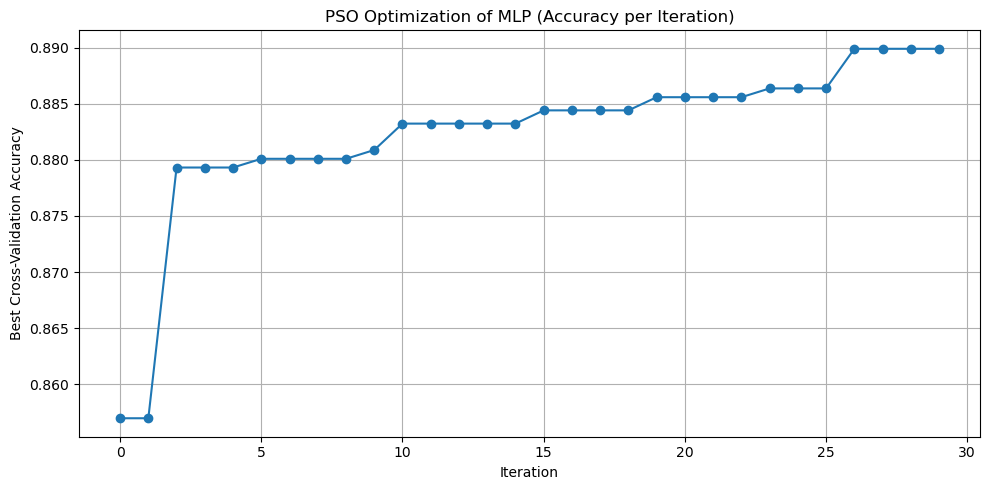

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from pyswarms.single import GlobalBestPSO
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
dataset = fetch_ucirepo(id=69)
X_raw = dataset.data.features
y_raw = dataset.data.targets

X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Setup
activation_options = ['relu', 'tanh', 'logistic']
solver_options = ['adam', 'sgd', 'lbfgs']

n_particles = 10
dimensions = 5
max_iter = 30
np.random.seed(42)

# Step 3: Define bounds + init
bounds = (
    np.array([10, 0, 0.0001, 0.00001, 0]),   # hidden_layer_size, activation, lr, alpha, solver
    np.array([100, 2, 0.1, 0.1, 2])
)
init_pos = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_particles, dimensions))

# Step 4: PSO objective
def objective_function(swarm):
    losses = []
    for params in swarm:
        try:
            n_hidden = int(round(params[0]))
            act_idx = int(round(params[1]))
            lr_init = float(params[2])
            alpha = float(params[3])
            solver_idx = int(round(params[4]))

            if (act_idx not in [0,1,2]) or solver_idx not in [0,1,2]:
                losses.append(1.0)
                continue

            model = MLPClassifier(
                hidden_layer_sizes=(n_hidden,),
                activation=activation_options[act_idx],
                learning_rate_init=lr_init,
                alpha=alpha,
                solver=solver_options[solver_idx],
                max_iter=300,
                random_state=42
            )
            score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
            losses.append(-score)  # minimize -accuracy
        except:
            losses.append(1.0)
    return np.array(losses)

# Step 5: Run PSO
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dimensions,
    options=options,
    bounds=bounds,
    init_pos=init_pos
)
cost, best_pos = optimizer.optimize(objective_function, iters=max_iter)

# Step 6: Decode best hyperparameters
best_hidden = int(round(best_pos[0]))
best_act = activation_options[int(round(best_pos[1]))]
best_lr = float(best_pos[2])
best_alpha = float(best_pos[3])
best_solver = solver_options[int(round(best_pos[4]))]

print("\n✅ Best MLP Parameters from PSO:")
print(f"   hidden_layer_sizes = ({best_hidden},)")
print(f"   activation = '{best_act}'")
print(f"   learning_rate_init = {best_lr}")
print(f"   alpha = {best_alpha}")
print(f"   solver = '{best_solver}'")

# Step 7: Final evaluation
final_model = MLPClassifier(
    hidden_layer_sizes=(best_hidden,),
    activation=best_act,
    learning_rate_init=best_lr,
    alpha=best_alpha,
    solver=best_solver,
    max_iter=300,
    random_state=42
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
print(f"🎯 Final test accuracy: {final_acc:.4f}")

# Step 8: Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(-np.array(optimizer.cost_history), marker='o')
plt.title("PSO Optimization of MLP (Accuracy per Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Best Cross-Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
